In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [3]:
seed = 1

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points, flat2mat, mat2flat)
from models.utils import box_nms

In [7]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [8]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.001,
            'descriptor_size': 256,
            'batch_size': 2,
            'epochs': 25,
            'learning_rate': 0.001,
            'lambda_d': 0.05,
            'descriptor_size': 256,
            'positive_margin': 1.0,
            'negative_margin': 0.2,
            'lambda_loss': 10000,
            'nms': 4,
            'top_k': 1000
    }

In [9]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size,
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [10]:
def shared_encoder(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True, 'activation': tf.nn.relu,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    params_pool = {'padding': 'SAME', 'data_format': model_config['data_format']}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool", **params_pool)(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool", **params_pool)(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool", **params_pool)(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return conv8

In [11]:
def detector_head(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

    prob = tf.nn.softmax(x, axis=cindex)
    # Strip the extra “no interest point” dustbin
    prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
    prob = tf.nn.depth_to_space(
              prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    prob = tf.squeeze(prob, axis=cindex)
    return {'logits': x, 'prob': prob}

In [12]:
def detector_loss(keypoint_map, logits, model_config, valid_mask=None):
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
    valid_mask = valid_mask[..., tf.newaxis]  # for GPU
    valid_mask = tf.cast(valid_mask, tf.float32)
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.cast(valid_mask, tf.int64)
#     labels = labels * valid_mask
#     loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits, weights=valid_mask)
    return loss

In [13]:
def model_metrics(y_true, y_pred, valid_mask):
    if model_config['nms']:
        prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred)
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
#     pred = tf.expand_dims(pred, axis = 3)
    pred = valid_mask * pred
    labels = y_true
    precision = tf.math.reduce_sum(pred * labels) / tf.math.reduce_sum(pred)
    recall = tf.math.reduce_sum(pred * labels) / tf.math.reduce_sum(labels)
#     return {'precision': precision, 'recall': recall}
    return precision

In [14]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        metrics = self.metrics_fn(inputs[0], inputs[1]['prob'], valid_mask = inputs[2])
        self.add_loss(tf.math.reduce_mean(loss))
        self.add_metric(metrics, name = 'precision')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape1, input_shape2, input_shape3):
    images_inputs = Input(shape = input_shape1, name = 'image')
    valid_masks_inputs = Input(shape = input_shape2, name = 'valid_mask')
    warped_points_inputs = Input(shape = input_shape3, name = 'keypoints')
    
    encoder_output = shared_encoder(images_inputs, model_config=model_config)
    output = detector_head(encoder_output, model_config=model_config)
    
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [15]:
model = net(input_shape1 = (240, 320, 1), input_shape2 = (240, 320), input_shape3 = (240, 320))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


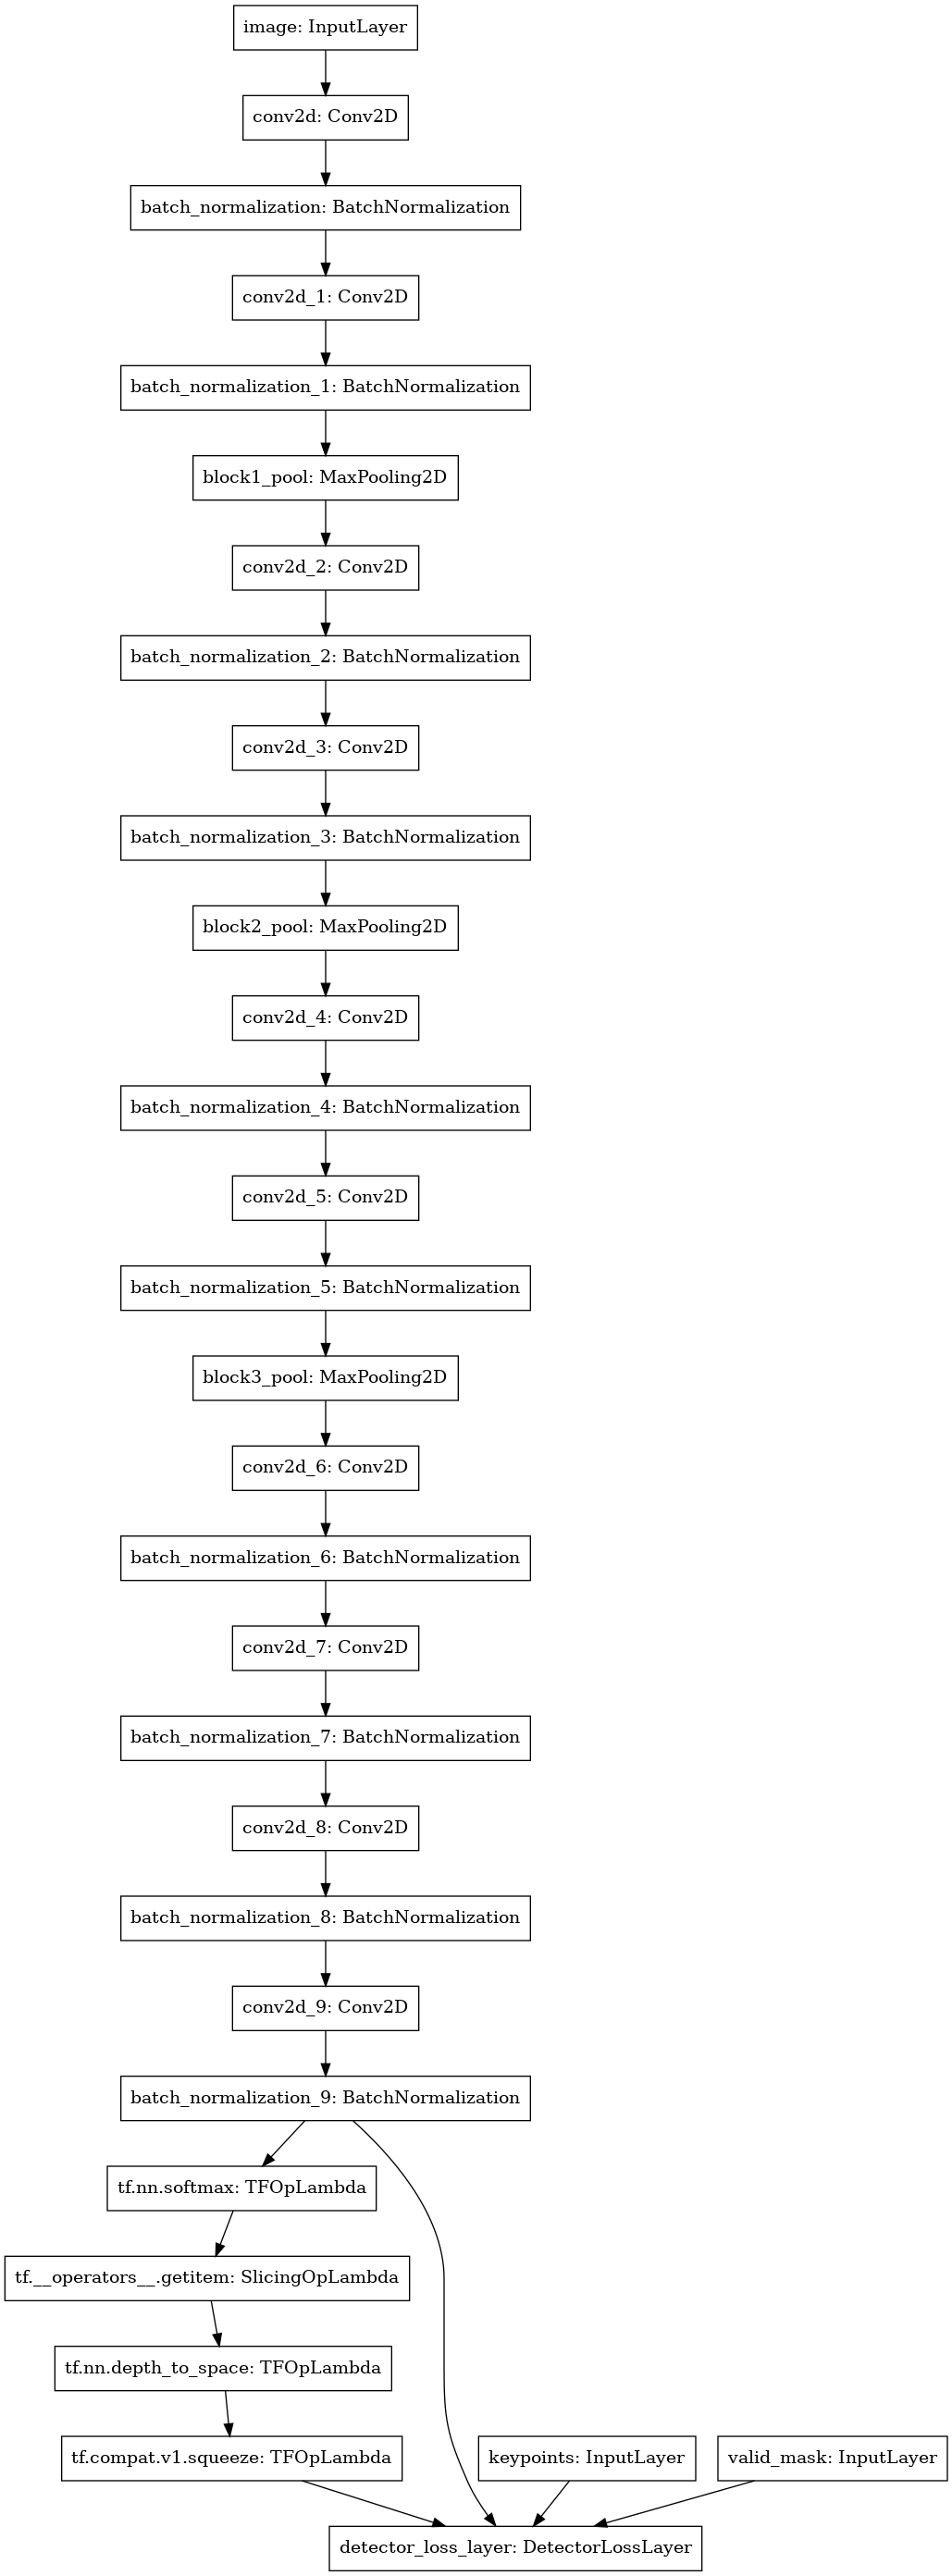

In [16]:
# model.summary()
keras.utils.plot_model(model, rankdir="TB", expand_nested=True)

In [17]:
model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-120x160-synth-aug-100322')

In [18]:
# Make changes here for illumination vs viewpoint

config = {
    'data':{
        'name': 'patches_dataset',
        'dataset': 'hpatches',  # 'coco' 'hpatches'
        'alteration': 'i',  # 'all' 'i' 'v'
        'preprocessing':{'resize': [240, 320]},  # False for coco
        'truncate': False,
    },
    'augmentation':{
        'homographic':{
            'valid_border_margin':3
        },
    },
    'nms':4,
    'top_k':1000,
    'detection_threshold':.001,
}

In [19]:
# Make changes here for illumination vs viewpoint

# output_dir = '/root/Internship-Valeo/Project/exports/superpoint_hpatches-i'
output_dir = '/root/Internship-Valeo/Project/exports/detector_repeatability/magic-point_hpatches-repeatability-i'

In [20]:
dataset_folder = 'HPatches'
base_path = Path(DATA_PATH, dataset_folder)
folder_paths = [x for x in base_path.iterdir() if x.is_dir()]
image_paths = []
warped_image_paths = []
homographies = []
for path in folder_paths:
    if config['data']['alteration'] == 'i' and path.stem[0] != 'i':
        continue
    if config['data']['alteration'] == 'v' and path.stem[0] != 'v':
        continue
    num_images = 1 if config['data']['dataset'] == 'coco' else 5
    file_ext = '.ppm' if config['data']['dataset'] == 'hpatches' else '.jpg'
    for i in range(2, 2 + num_images):
        image_paths.append(str(Path(path, "1" + file_ext)))
        warped_image_paths.append(str(Path(path, str(i) + file_ext)))
        homographies.append(np.loadtxt(str(Path(path, "H_1_" + str(i)))))
if config['data']['truncate']:
    image_paths = image_paths[:config['truncate']]
    warped_image_paths = warped_image_paths[:config['truncate']]
    homographies = homographies[:config['truncate']]
files = {'image_paths': image_paths,
                 'warped_image_paths': warped_image_paths,
                 'homography': homographies}

In [21]:
def adapt_homography_to_preprocessing(homography, image_shape, warped_image_shape):
    H = tf.cast(homography, tf.float32)
    source_size = tf.cast(image_shape, tf.float32)
    source_warped_size = tf.cast(warped_image_shape, tf.float32)
    target_size = tf.cast(tf.convert_to_tensor(config['data']['preprocessing']['resize']),
                                  tf.float32)

    # Compute the scaling ratio due to the resizing for both images
    s = tf.reduce_max(tf.divide(target_size, source_size))
    up_scale = tf.linalg.diag(tf.stack([1. / s, 1. / s, tf.constant(1.)]))
    warped_s = tf.reduce_max(tf.divide(target_size, source_warped_size))
    down_scale = tf.linalg.diag(tf.stack([warped_s, warped_s, tf.constant(1.)]))

    # Compute the translation due to the crop for both images
    pad_y = tf.cast(((source_size[0] * s - target_size[0]) / tf.constant(2.0)), tf.int32)
    pad_x = tf.cast(((source_size[1] * s - target_size[1]) / tf.constant(2.0)), tf.int32)
    translation = tf.stack([tf.constant(1), tf.constant(0), pad_x, 
                                    tf.constant(0), tf.constant(1), pad_y,
                                    tf.constant(0),tf.constant(0), tf.constant(1)])
    translation = tf.cast(tf.reshape(translation, [3,3]), tf.float32)
    pad_y = tf.cast(((source_warped_size[0] * warped_s - target_size[0])
                                 / tf.constant(2.0)), tf.int32)
    pad_x = tf.cast(((source_warped_size[1] * warped_s - target_size[1])
                                 / tf.constant(2.0)), tf.int32)
    warped_translation = tf.stack([tf.constant(1), tf.constant(0), -pad_x, 
                                           tf.constant(0), tf.constant(1), -pad_y,
                                           tf.constant(0),tf.constant(0), tf.constant(1)])
    warped_translation = tf.cast(tf.reshape(warped_translation, [3,3]), tf.float32)
    H = warped_translation @ down_scale @ H @ up_scale @ translation
    return H

In [22]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_path, warped_image_path, homography,                  
                 image_size_x = 320, image_size_y = 240, batch_size = 2):
        
        self.__image_path = image_path
        self.__homography = homography
        self.__warped_image_path = warped_image_path
        self.__image_size_x = image_size_x
        self.__image_size_y = image_size_y
        self.__batch_size = batch_size
        self.on_epoch_end()
        
    def __getitem__(self, index):
        images = []
        homography_list = []
        warped_images = []
        valid_masks = []
        
        if (index + 1)*self.__batch_size > len(self.__image_path):
            self.__batch_size = len(self.__image_path) - index * self.__batch_size
            
        batch_img_files = self.__image_path[index * self.__batch_size:(index + 1) * self.__batch_size]
        batch_warped_img_files = self.__warped_image_path[
            index * self.__batch_size:(index + 1) * self.__batch_size]
        batch_homography = self.__homography[index * self.__batch_size:(index + 1) * self.__batch_size]
        for img_file, warped_img_file, homography, itr in zip(
            batch_img_files, batch_warped_img_files, batch_homography, range(self.__batch_size)):
            
            image = cv2.imread(img_file, 0)
            source_image_shape = image.shape
            image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
            image = np.expand_dims(image, axis = 2)
            image_shape = tf.shape(image)[:2]    
            # read warped image

            warped_image = cv2.imread(warped_img_file, 0)
            source_warped_image_shape = warped_image.shape
            warped_image = cv2.resize(warped_image , (self.__image_size_x , self.__image_size_y))
            warped_image = np.expand_dims(warped_image, axis = 2)
            
            homography = adapt_homography_to_preprocessing(homography, source_image_shape, 
                                                           source_warped_image_shape)
            
            homography = mat2flat(homography)
            homography = tf.squeeze(homography)
            homography_list.append(homography)
            # compute valid mask
            valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
            valid_masks.append(valid_mask)
            warped_image = warped_image / 255.0
            warped_images.append(warped_image) 
            image = image / 255.0
            images.append(image)   
              
        images = np.array(images)
        warped_images = np.array(warped_images)
        homography_list = np.array(homography_list)
        valid_masks = np.array(valid_masks)
        return [images, homography_list, warped_images, valid_masks]

           
    def __len__(self):
        return int(np.ceil(len(self.__image_path) / float(self.__batch_size)))
    
    def on_epoch_end(self):
        pass

In [23]:
image_path = files['image_paths']
warped_image_path = files['warped_image_paths']
homography = files['homography']
test_set = DataGen(image_path, warped_image_path, homography, batch_size = 1)

In [24]:
x = test_set.__getitem__(14)

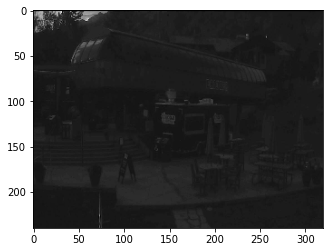

In [25]:
plt.imshow(x[2][0],cmap = 'gray')

In [26]:
x[0].shape

(1, 240, 320, 1)

In [27]:
x[1].shape

(1, 8)

In [28]:
x[2].shape

(1, 240, 320, 1)

In [29]:
x[3].shape

(1, 240, 320)

In [30]:
prob = model.get_layer('tf.compat.v1.squeeze').output
m = keras.models.Model(inputs = model.input[0], outputs = prob)

In [31]:
for i in range(len(files['image_paths'])):
    filename = str(i)
    filepath = Path(output_dir, '{}.npz'.format(filename))
    
    x = test_set.__getitem__(i)
    
    y_pred1 = m.predict(x[0])

    if model_config['nms']:
        prob1 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred1)
#         pred1 = tf.cast(tf.greater_equal(prob1, model_config['detection_threshold']), tf.float32)
    

    y_pred2 = m.predict(x[2])

    if model_config['nms']:
        prob2 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred2)
#         pred2 = tf.cast(tf.greater_equal(prob2, model_config['detection_threshold']), tf.float32)
#     prob2 = prob2*x[3]
    homography = x[1]
    homography = flat2mat(homography)
    pred = {'image': x[0][0],
            'warped_image': x[2][0],
            'prob': prob1[0],
            'warped_prob': prob2[0],
            'homography': homography[0]}
    
    
    np.savez_compressed(filepath, **pred)